In [1]:
import pandas as pd 

In [2]:
def report(df,place=0):
    column_names = df.columns.to_list()
    row = df.iloc[place]
    for i in range(0,len(column_names)):
        print(column_names[i],':',row[i])

#### Загрузка таблицы

In [3]:
df = pd.read_csv("5710_test_b.csv",';')
df.fillna(0, inplace=True)

#### Приведение смещений к числу

In [4]:
def convert_to_int(s):
    return float(s.rsplit(',', 2)[0].replace(' ',''))/1000

df['bias_top']=df['bias_top'].apply(convert_to_int)
df['bias_bottom']=df['bias_bottom'].apply(convert_to_int)

report(df)

bias_top : 1.057
bias_bottom : -10798.26
id : 34 598
date : 30.07.2020 8:53:25
phone : 9104995710
ttl : bidlist*a1596088402059b1596088401894c1596088401894d1596099201273e1596099202631f1596088403376g1596088403376h1596088405325i1596088405399j1596099205158


#### Определим время жизни пакетов

In [5]:
def get_len(last_string):
    splitters = ['*','a','b','c','d','e','f','g','h','i','j']
    ttl = []
    for splitter in splitters:
        new_string = last_string.split(splitter)
        last_string = new_string[1]
        ttl.append(new_string[0])
    ttl.append(last_string)
    first_value = int(ttl[2])
    last_value = int(ttl[-2:][0])
    return last_value-first_value

df['dev_len']=df['ttl'].apply(get_len)

report(df)

bias_top : 1.057
bias_bottom : -10798.26
id : 34 598
date : 30.07.2020 8:53:25
phone : 9104995710
ttl : bidlist*a1596088402059b1596088401894c1596088401894d1596099201273e1596099202631f1596088403376g1596088403376h1596088405325i1596088405399j1596099205158
dev_len : 3340


#### Возьмем запись с минимальной длительностью в мс

In [6]:
minimal_rec = df.sort_values(by=['dev_len']).iloc[0]
minimal_rec['dev_len']

3340

#### Выделим функцию

In [7]:
def get_func(last_string):
    return last_string.split('*')[0]
df['func']=df['ttl'].apply(get_func)

report(df)

bias_top : 1.057
bias_bottom : -10798.26
id : 34 598
date : 30.07.2020 8:53:25
phone : 9104995710
ttl : bidlist*a1596088402059b1596088401894c1596088401894d1596099201273e1596099202631f1596088403376g1596088403376h1596088405325i1596088405399j1596099205158
dev_len : 3340
func : bidlist


#### Заполним таймеры этапов

In [8]:
def get_timers(last_string,step):
    splitters = ['*','a','b','c','d','e','f','g','h','i','j']
    ttl = []
    for splitter in splitters:
        new_string = last_string.split(splitter)
        last_string = new_string[1]
        ttl.append(new_string[0])
    ttl.append(last_string)    
    return int(ttl[step])/1000

timer_columns = ['a','b','c','d','e','f','g','h','i','j']
for i in range(0,len(timer_columns)):
    column_name = timer_columns[i]
    df[column_name]=df['ttl'].apply(get_timers,step=i+2)

report(df)

bias_top : 1.057
bias_bottom : -10798.26
id : 34 598
date : 30.07.2020 8:53:25
phone : 9104995710
ttl : bidlist*a1596088402059b1596088401894c1596088401894d1596099201273e1596099202631f1596088403376g1596088403376h1596088405325i1596088405399j1596099205158
dev_len : 3340
func : bidlist
a : 1596088402.059
b : 1596088401.894
c : 1596088401.894
d : 1596099201.273
e : 1596099202.631
f : 1596088403.376
g : 1596088403.376
h : 1596088405.325
i : 1596088405.399
j : 1596099205.158


#### Вычислим время между инстанциями

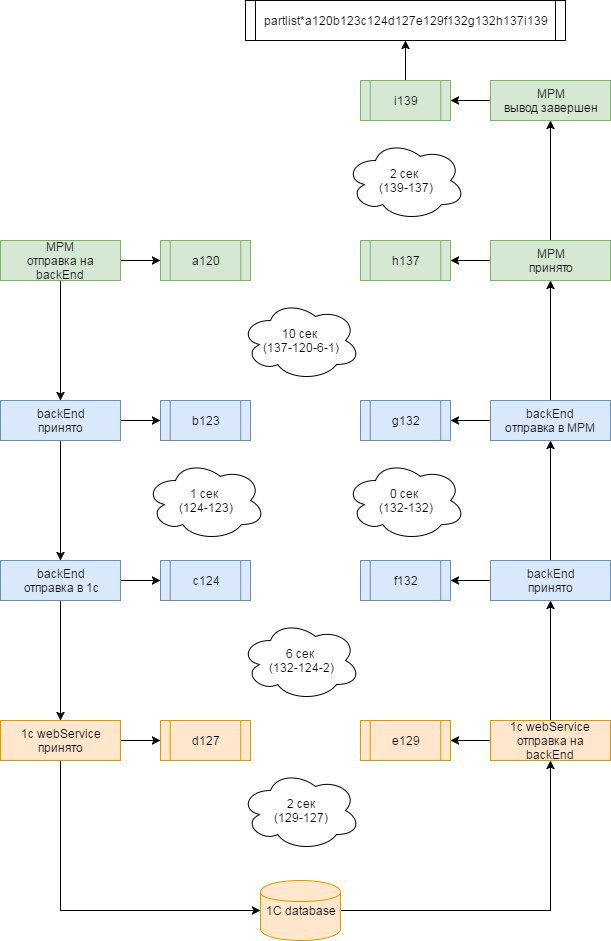

In [9]:
df['ab_mrm_to_back']      = df.b - df.a + df.bias_top    
df['bc_back_to_back']     = df.c - df.b
df['cd_back_to_1c']       = df.d - df.c + df.bias_bottom - df.bias_top
df['de_1c_to_1c']         = df.e - df.d
df['ef_1c_to_back']       = df.f - df.e + df.bias_top - df.bias_bottom
df['fg_back_to_back']     = df.g - df.f
df['gh_back_to_mrm']      = df.h - df.g - df.bias_top
df['hi_mrm_to_mrm']       = df.i - df.h

report(df,0)

bias_top : 1.057
bias_bottom : -10798.26
id : 34 598
date : 30.07.2020 8:53:25
phone : 9104995710
ttl : bidlist*a1596088402059b1596088401894c1596088401894d1596099201273e1596099202631f1596088403376g1596088403376h1596088405325i1596088405399j1596099205158
dev_len : 3340
func : bidlist
a : 1596088402.059
b : 1596088401.894
c : 1596088401.894
d : 1596099201.273
e : 1596099202.631
f : 1596088403.376
g : 1596088403.376
h : 1596088405.325
i : 1596088405.399
j : 1596099205.158
ab_mrm_to_back : 0.8920000381469726
bc_back_to_back : 0.0
cd_back_to_1c : 0.061999948501368696
de_1c_to_1c : 1.3580000400543213
ef_1c_to_back : 0.0619998855599988
fg_back_to_back : 0.0
gh_back_to_mrm : 0.8920001201629639
hi_mrm_to_mrm : 0.07399988174438477


'''
df['time_de']=df.e-df.d # 1C webService -> 1C database -> 1C webService
df['time_cf']=df.f-df.c-df.time_de # Backend -> 1c webService -> Backend
df['time_bg']=df.g-df.b-df.time_de-df.time_cf # Backend -> Backend
df['time_ah']=df.h-df.a-df.time_de-df.time_cf-df.time_bg # Device -> Device
df['time_hi']=df.i-df.h # Device caclulation
'''
df['inside_1c']     =df.e-df.d # 1C webService -> 1C database -> 1C webService
df['backend_1c']    =df.f-df.c-df.inside_1c # Backend -> 1c webService -> Backend
df['inside_backend']=df.g-df.b-df.inside_1c-df.backend_1c # Backend -> Backend
df['device_backend']=df.h-df.a-df.inside_1c-df.backend_1c-df.inside_backend # Device -> Device
df['inside_device']=df.i-df.h # Device caclulation

report(df)

#### Удалим временные колонки

df.drop(['a','b','c','d','e','f','g','h','i','j'], axis='columns', inplace=True)

report(df)

df[df.func=='bidlist']

#### График по событиям

In [10]:
df.iloc()[0]

bias_top                                                       1.057
bias_bottom                                                 -10798.3
id                                                            34 598
date                                              30.07.2020 8:53:25
phone                                                     9104995710
ttl                bidlist*a1596088402059b1596088401894c159608840...
dev_len                                                         3340
func                                                         bidlist
a                                                        1.59609e+09
b                                                        1.59609e+09
c                                                        1.59609e+09
d                                                         1.5961e+09
e                                                         1.5961e+09
f                                                        1.59609e+09
g                                 

In [20]:
for rec in df.iloc():
    timer = []
    timer.append(rec.)
    print(rec)
    break
    '''rec.plot(
            kind='area',
            x='date',
            #y=['time_de','time_cf','time_bg','time_ah','time_hi'],
            y=['inside_1c','backend_1c','inside_backend','device_backend','inside_device'],
            title = func,
            #subplots=True,
            figsize=(15,4)
        )'''

bias_top                                                       1.057
bias_bottom                                                 -10798.3
id                                                            34 598
date                                              30.07.2020 8:53:25
phone                                                     9104995710
ttl                bidlist*a1596088402059b1596088401894c159608840...
dev_len                                                         3340
func                                                         bidlist
a                                                        1.59609e+09
b                                                        1.59609e+09
c                                                        1.59609e+09
d                                                         1.5961e+09
e                                                         1.5961e+09
f                                                        1.59609e+09
g                                 

In [ ]:
def plot_events(df,limit = 3):
    for func in df['func'].unique():
        df[df.func==func].plot(
            kind='area',
            x='date',
            #y=['time_de','time_cf','time_bg','time_ah','time_hi'],
            y=['inside_1c','backend_1c','inside_backend','device_backend','inside_device'],
            title = func,
            #subplots=True,
            figsize=(15,4)
        )
plot_functions(df)

#### График по функциям

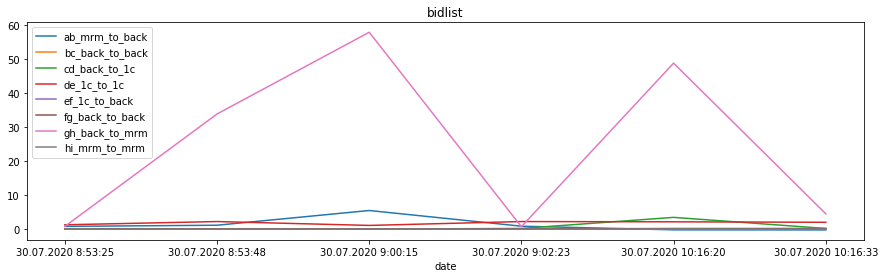

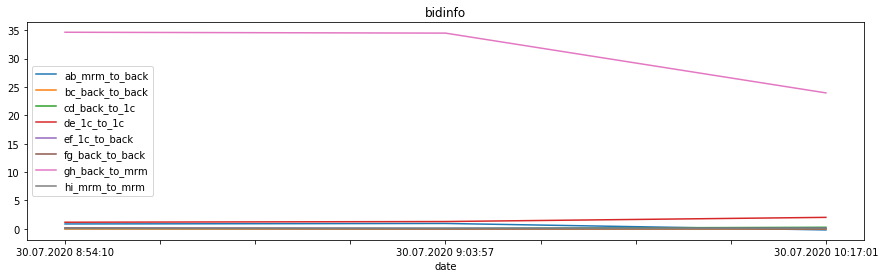

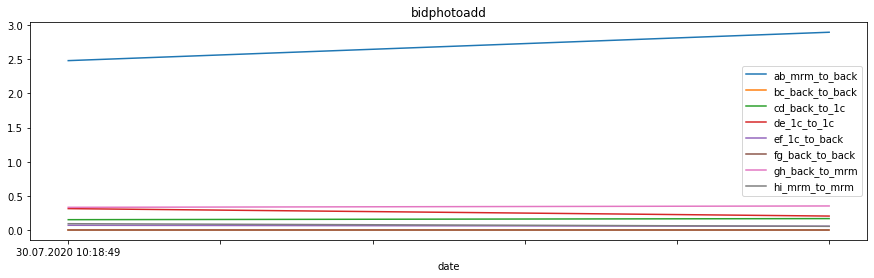

In [24]:
def plot_functions(df):
    for func in df['func'].unique():
        df[df.func==func].plot(
            #kind='area',
            x='date',
            #y=['time_de','time_cf','time_bg','time_ah','time_hi'],
            y=[
                'ab_mrm_to_back',
                'bc_back_to_back',
                'cd_back_to_1c',
                'de_1c_to_1c',
                'ef_1c_to_back',
                'fg_back_to_back',
                'gh_back_to_mrm',
                'hi_mrm_to_mrm',
            ],
            title = func,
            #subplots=True,
            figsize=(15,4)
        )
plot_functions(df)

In [ ]:
def plot_average(df):

    #df.groupby(['date']).size().unstack().plot(kind='bar',stacked=True)
    #plt.show()

    df.plot(
        kind='area',
        x='date',
        #y=['time_de','time_cf','time_bg','time_ah','time_hi'],
        y=['inside_1c','backend_1c','inside_backend','device_backend','inside_device'],
        title = 'log ttl',
        #subplots=True,
        figsize=(15,15)
    )
plot_average(df)

In [ ]:
def plot_spam(df):
    df.plot(
        kind='area',
        x='date',
        y=['spam_count'],
        title = 'spam',
        figsize=(15,5)
    )